In [413]:
# # bolier plate

# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir("/content/drive/MyDrive/cs330")

In [414]:
import warnings 

warnings.simplefilter("ignore")


## Setup

In [415]:
from typing import *
import numpy as np
import os
import random
import tensorflow as tf
from scipy import misc

In [416]:
from pathlib import Path

__dirname = Path("__file__").parent
__dirname
paths = [ p for p in __dirname.glob("omniglot_resized/Atlantean/*")]
labels = [i for i in range(len(paths))]

In [417]:
from get_images import get_images
images_labels: List[Tuple[int, str]] = get_images(
    paths=paths,
    labels=labels,
)


* `images_labels` returns `List[Tuple[int, str]]` list of tuple of integer and string.

In [418]:
images_labels[0]

(23, 'omniglot_resized/Atlantean/character14/1024_13.png')

uint8
(28, 28)


<AxesSubplot:>

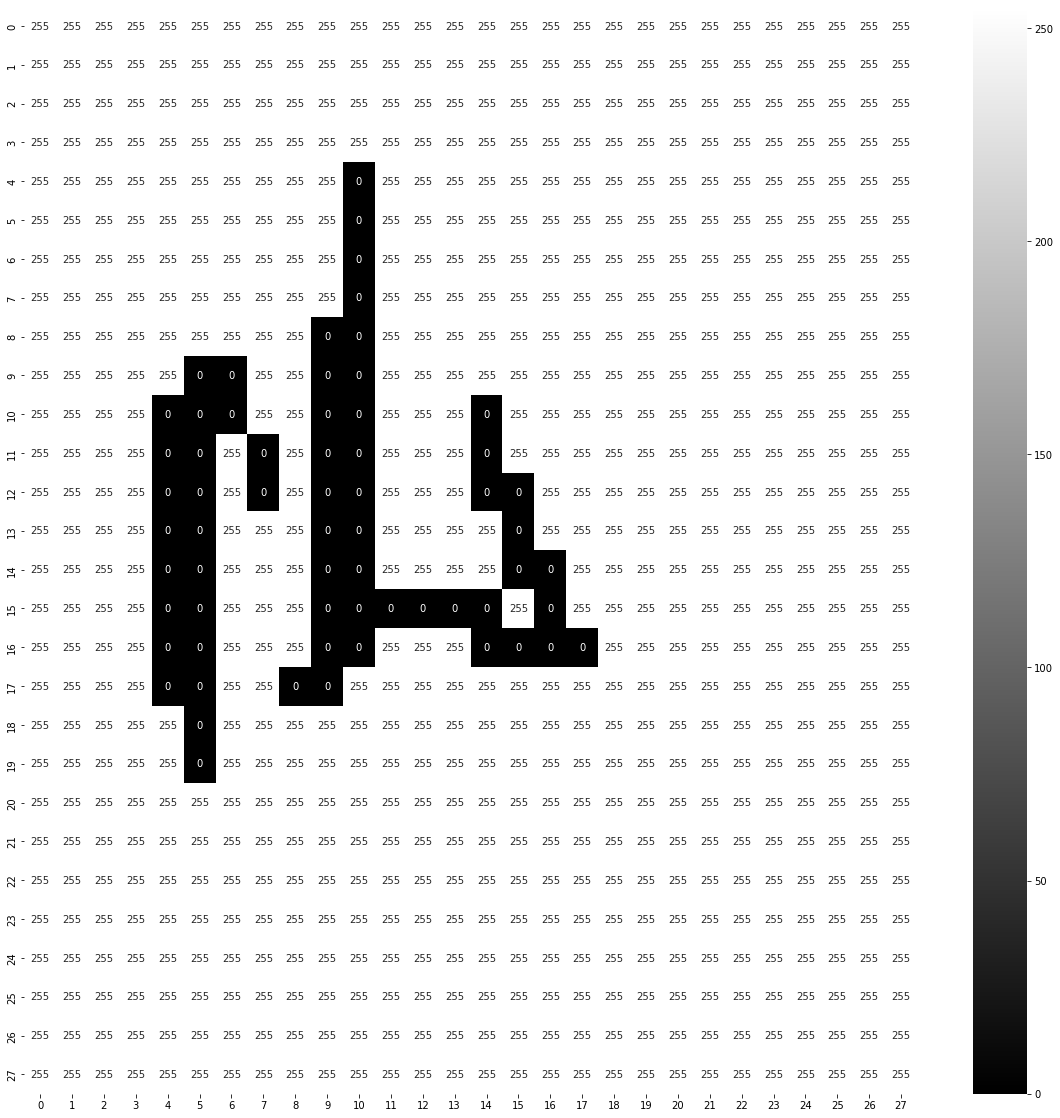

In [419]:
import matplotlib.pyplot as plt
import seaborn
import imageio


label, filename  = images_labels[0]
image = imageio.imread(filename)
print(image.dtype)
print(image.shape)

fig, ax = plt.subplots(figsize=(20,20))
seaborn.heatmap(image, cmap="gray", fmt="d", annot=True, ax=ax)

<AxesSubplot:>

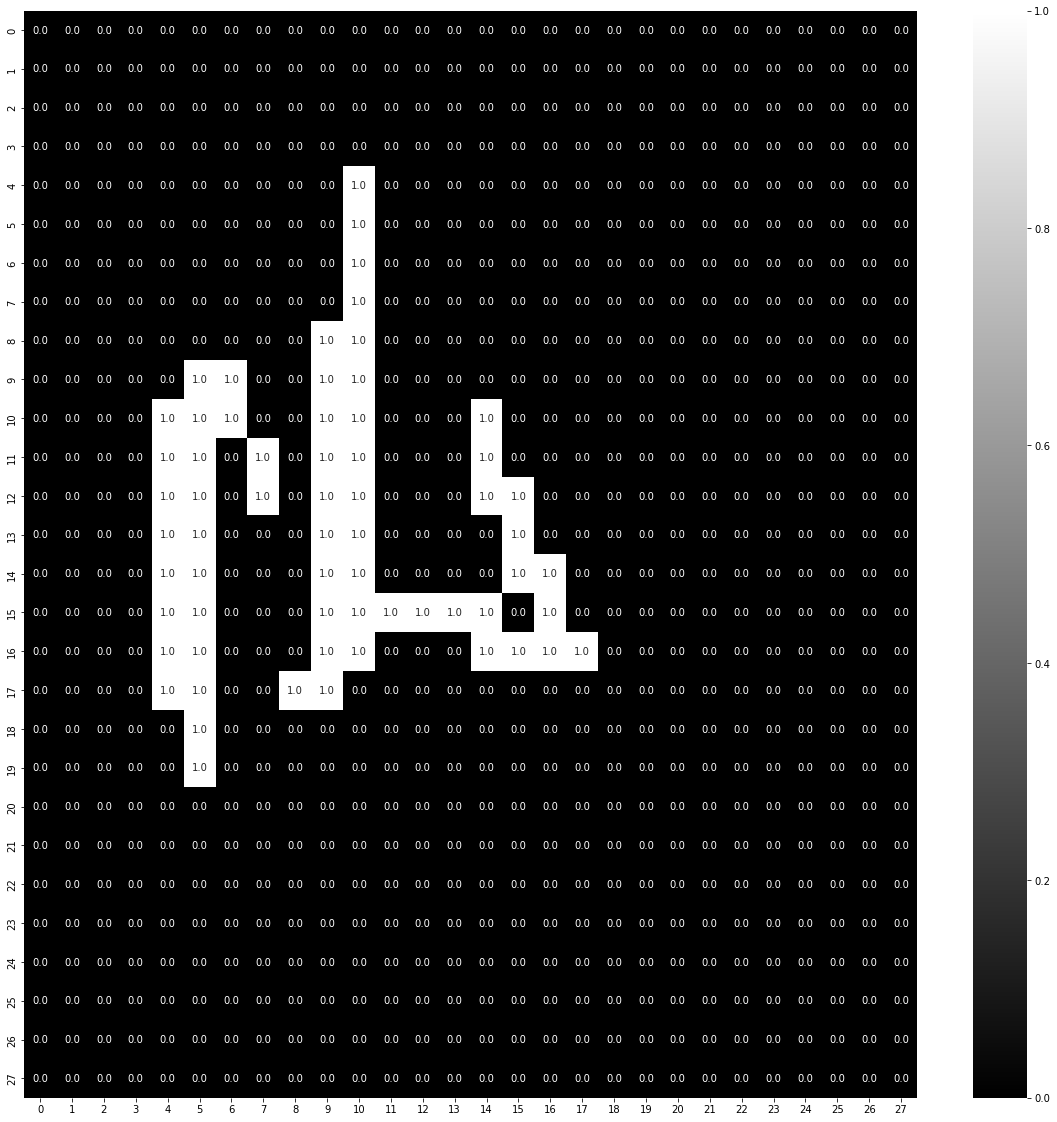

In [420]:
from image_file_to_array import image_file_to_array

fig, ax = plt.subplots(figsize=(20,20))

seaborn.heatmap(
    image_file_to_array(
        filename=filename,
        dim_input=28*28,
    ).reshape(28, 28), 
    cmap="gray", 
    fmt=".1f", 
    annot=True, 
    ax=ax,
)    

In [421]:



# class DataGenerator(object):
#     """
#     Data Generator capable of generating batches of Omniglot data.
#     A "class" is considered a class of omniglot digits.
#     """

#     def __init__(self, num_classes, num_samples_per_class, config={}):
#         """
#         Args:
#             num_classes: Number of classes for classification (K-way)
#             num_samples_per_class: num samples to generate per class in one batch
#             batch_size: size of meta batch size (e.g. number of functions)
#         """
#         self.num_samples_per_class = num_samples_per_class
#         self.num_classes = num_classes

#         data_folder = config.get('data_folder', './omniglot_resized')
#         self.img_size = config.get('img_size', (28, 28))

#         self.dim_input = np.prod(self.img_size)
#         self.dim_output = self.num_classes

#         character_folders = [os.path.join(data_folder, family, character)
#                              for family in os.listdir(data_folder)
#                              if os.path.isdir(os.path.join(data_folder, family))
#                              for character in os.listdir(os.path.join(data_folder, family))
#                              if os.path.isdir(os.path.join(data_folder, family, character))]

#         random.seed(1)
#         random.shuffle(character_folders)
#         num_val = 100
#         num_train = 1100
#         self.metatrain_character_folders = character_folders[: num_train]
#         self.metaval_character_folders = character_folders[
#             num_train:num_train + num_val]
#         self.metatest_character_folders = character_folders[
#             num_train + num_val:]

#     def sample_batch(self, batch_type, batch_size):
#         """
#         Samples a batch for training, validation, or testing
#         Args:
#             batch_type: train/val/test
#         Returns:
#             A a tuple of (1) Image batch and (2) Label batch where
#             image batch has shape [B, K, N, 784] and label batch has shape [B, K, N, N]
#             where B is batch size, K is number of samples per class, N is number of classes
#         """
#         if batch_type == "train":
#             folders = self.metatrain_character_folders
#         elif batch_type == "val":
#             folders = self.metaval_character_folders
#         else:
#             folders = self.metatest_character_folders

#         #############################
#         #### YOUR CODE GOES HERE ####
#         pass
#         #############################

#         return all_image_batches.astype(np.float32), all_label_batches.astype(np.float32)


In [422]:
from pathlib import Path
import random
from typing import *

class DataGenerator(object):
    """
    Data Generator capable of generating batches of Omniglot data.
    A "class" is considered a class of omniglot digits.
    """

    def __init__(
        self,
        num_classes: int,
        num_samples_per_class: int,
        data_folder: str = "./omniglot_resized",
        img_size=(28, 28),
    ):
        """
        Args:
            num_classes: Number of classes for classification (K-way)
            num_samples_per_class: num samples to generate per class in one batch
            batch_size: size of meta batch size (e.g. number of functions)
        """


        self.num_samples_per_class = num_samples_per_class
        self.num_classes = num_classes
        self.img_size: Tuple[int, int] = img_size
        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes

        character_folders = []

        for family in Path(data_folder).glob("*"):
            if family.is_dir():
                for character in family.glob("*"):
                    if character.is_dir():
                        character_folders.append(character)

        random.seed(1)
        random.shuffle(character_folders)
        num_val = 100
        num_train = 1100
        self.metatrain_character_folders: List[Path] = character_folders[:num_train]
        self.metaval_character_folders: List[Path] = character_folders[
            num_train : num_train + num_val
        ]
        self.metatest_character_folders: List[Path] = character_folders[num_train + num_val :]


    def sample_batch(self, batch_type, batch_size, one_hot=True):
        """
        Samples a batch for training, validation, or testing
        Args:
            batch_type: train/val/test
        Returns:
            A a tuple of (1) Image batch and (2) Label batch where
            image batch has shape [B, K, N, 784] and label batch has shape [B, K, N, N]
            where B is batch size, K is number of samples per class, N is number of classes
        """
        if batch_type == "train":
            folders = self.metatrain_character_folders
        elif batch_type == "val":
            folders = self.metaval_character_folders
        else:
            folders = self.metatest_character_folders

        N: int = self.num_classes
        K: int = self.num_samples_per_class
        
        all_image_batches = []
        all_label_batches = []

        for i, char_img_folder in enumerate(folders): 
            if one_hot:
                label = np.zeros(shape=(K, self.num_classes))
                label[:,i % N] = 1
            else :
                label = np.full(shape=K, fill_value= i%N)
            sample_img_paths: List[Path] = [p for p in char_img_folder.glob("*.png")]
            random.shuffle(sample_img_paths)

            all_image_batches.append(
                np.stack([
                    image_file_to_array(sample_img_paths.pop()) for _ in range(K)
                ])
            )
            all_label_batches.append(label)

        all_image_batches = np.stack(all_image_batches)[:1100 - 1100%(N*batch_size*K)]
        all_label_batches = np.stack(all_label_batches)[:1100 - 1100%(N*batch_size*K)]

        all_image_batches = all_image_batches.reshape(-1, batch_size, N, K, 784) 
        all_image_batches = np.swapaxes(all_image_batches, 2, 3)
        if one_hot:
            all_label_batches = all_label_batches.reshape(-1, batch_size, N, K, N)
        else : 
            all_label_batches = all_label_batches.reshape(-1, batch_size, N, K)
        all_label_batches = np.swapaxes(all_label_batches, 2, 3)


        return (
            all_image_batches.astype(np.float32),
            all_label_batches.astype(np.float32),
        )



* image batch has shape `[B, K, N, 784]` and label batch has shape `[B, K, N, N]` where B is batch size, K is number of samples per class, N is number of classes

In [423]:
data_generator = DataGenerator(
    num_classes=4,
    num_samples_per_class=3,
)

In [462]:
def create_meta_trainset(all_image_batches, all_label_batches, ):
    num_batches, B, K, N, d = all_image_batches.shape
    
    labels_for_supportset = all_label_batches[:, :, :-1]   # (B, K- 1, N , N)
    masking_for_queryset = np.zeros_like(all_label_batches[:, :, -1:]) # (B, 1, N, N)
    train_labels = np.concatenate([
            labels_for_supportset, 
            masking_for_queryset
        ], axis=2,
    )

    

    meta_labels = np.argmax(all_label_batches[:,:,-1,:], axis=-1) # (B, 1, N)


    images_for_supportset = all_image_batches[:,:,:-1]
    
    images_for_queryset = all_image_batches[:,:,-1:]
    images_for_queryset = images_for_queryset.reshape(-1, N, d)
    meta_labels = meta_labels.reshape(-1, N)

    temp_images = []
    temp_labels = []

    for _images, _labels in zip(images_for_queryset, meta_labels):
        # _images.shape == 4 x 784
        # _labels.shape == 4
        index = np.arange(4)
        np.random.shuffle(index)
        index
        temp_images.append(_images[index])
        temp_labels.append(_labels[index])

    images_for_queryset = np.stack(temp_images).reshape(-1, B, 1, N, d)
    meta_labels = np.stack(temp_labels).reshape(-1, B, N)
    all_image_batches = np.concatenate([
        images_for_supportset, images_for_queryset
    ], axis=2)

    meta_inputs = np.concatenate([all_image_batches, train_labels], axis=-1)
    meta_inputs = meta_inputs.reshape(num_batches, B, -1, d + N)
    return meta_inputs, meta_labels,




In [463]:
meta_inputs, meta_labels = create_meta_trainset(*data_generator.sample_batch(
    batch_type="train", 
    batch_size=16, 
    one_hot=True,
))

In [469]:
meta_labels

array([[[2, 0, 3, 1],
        [2, 1, 3, 0],
        [2, 0, 1, 3],
        [0, 3, 1, 2],
        [3, 0, 1, 2],
        [2, 0, 3, 1],
        [2, 0, 1, 3],
        [0, 1, 3, 2],
        [0, 1, 2, 3],
        [2, 1, 3, 0],
        [3, 1, 2, 0],
        [3, 2, 1, 0],
        [0, 2, 3, 1],
        [0, 3, 2, 1],
        [1, 3, 2, 0],
        [3, 0, 2, 1]],

       [[3, 1, 2, 0],
        [0, 1, 3, 2],
        [3, 0, 2, 1],
        [3, 1, 0, 2],
        [0, 3, 1, 2],
        [3, 0, 1, 2],
        [1, 3, 2, 0],
        [0, 3, 1, 2],
        [3, 2, 1, 0],
        [3, 0, 1, 2],
        [1, 2, 0, 3],
        [3, 2, 1, 0],
        [3, 1, 2, 0],
        [0, 2, 3, 1],
        [0, 3, 1, 2],
        [2, 1, 0, 3]],

       [[2, 0, 1, 3],
        [1, 0, 2, 3],
        [3, 1, 2, 0],
        [0, 2, 1, 3],
        [0, 1, 2, 3],
        [0, 2, 3, 1],
        [3, 1, 0, 2],
        [1, 3, 0, 2],
        [0, 2, 3, 1],
        [2, 1, 0, 3],
        [2, 0, 3, 1],
        [3, 0, 2, 1],
        [2, 1, 3, 0],
      

In [471]:
meta_inputs[0, 0, :, -4:] # labels for metatrainset
# as you can see, the tail of matrix is masked with zero matrix.

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

In [472]:
meta_inputs[0, 0, :-4, -4:] # labels for metatrainset
# as you can see, the tail of matrix is masked with zero matrix.

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [473]:
meta_inputs[0, 0, -4: , -4:] # labels for metatrainset
# as you can see, the tail of matrix is masked with zero matrix.

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

In [518]:

def visualize_dataset(n_batches=0, n_task=0):
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10,10))
    axes = axes.reshape(-1)
    for i, row in enumerate(meta_inputs[n_batches, n_task, :, :]):
        flatten_image = row[:-4]
        label_vec = row[-4:]
        axes[i].imshow(flatten_image.reshape(28, 28))
        axes[i].set_title( "masked" if label_vec.sum() == 0 else np.argmax(label_vec))
    plt.show()
        

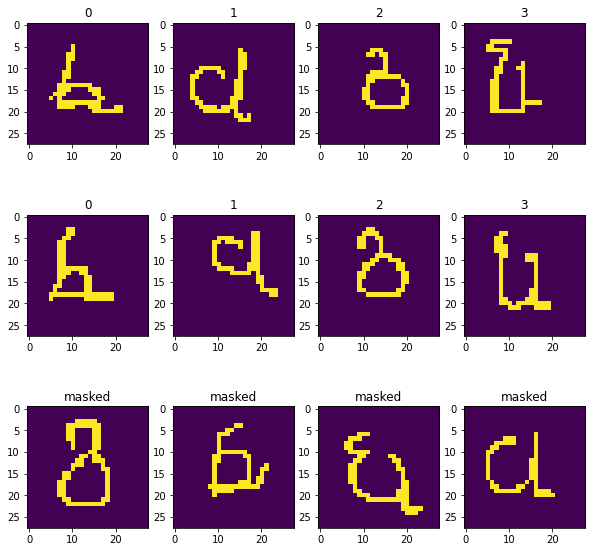

In [519]:
visualize_dataset()

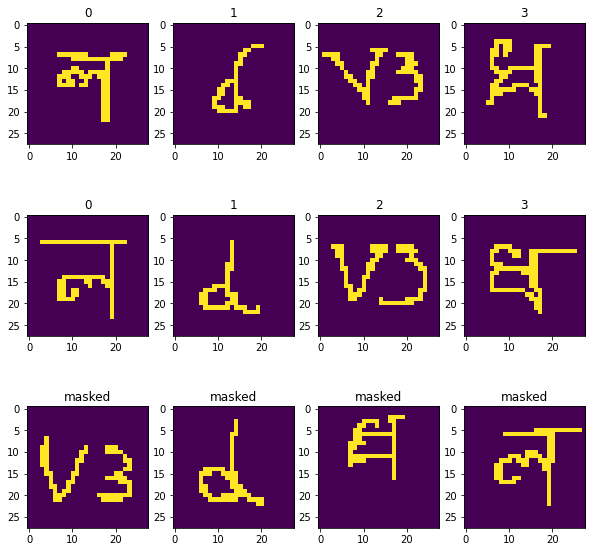

In [520]:
visualize_dataset(0, 1)

In [514]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
class MANN(nn.Module):
    def __init__(self, num_classes, num_samples, embed_size=784):
        super(MANN, self).__init__()
        self.num_classes = num_classes
        self.num_samples = num_samples
        self.embed_size = embed_size
        self.lstm1 = nn.LSTM(embed_size+num_classes, 128, batch_first=True) #Pytorch always has return_sequences=True
        self.lstm2 = nn.LSTM(128, num_classes, batch_first=True)

    def forward(self, inputs):
        x, _ = self.lstm1(inputs)
        x, _ = self.lstm2(x)

        return x[:, - self.num_classes:, :]

In [515]:
model = MANN(num_classes=4, num_samples=3)
criterion = nn.CrossEntropyLoss()

In [517]:
optim = torch.optim.Adam(params=model.parameters(), lr=0.00005)
model.train()
epoch = 2500
for i in range(epoch):
    for j, (input, label) in enumerate(zip(meta_inputs, meta_labels)):
        optim.zero_grad()
        input = torch.tensor(input)
        y_true = torch.tensor(label)
        y_pred = model(input)
        loss = criterion(y_pred, y_true)
        loss.backward()       
        optim.step()
        
        if j == 0 and i%50 == 49 :
            print(loss.item())

        

0.49677178263664246
0.4855474531650543
0.47933393716812134
0.47357603907585144
0.46743106842041016
0.6379879713058472
0.46135082840919495
0.4551076889038086
0.44436216354370117
0.4421246349811554
0.4509010314941406
0.43289610743522644
0.4310988783836365
0.4289408326148987
0.4267762303352356
0.42506328225135803
0.4237017035484314
0.4229927659034729
0.42333337664604187
0.4228978455066681
0.42272162437438965
0.42256295680999756
0.42240527272224426


KeyboardInterrupt: 